In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from dataset.ImageDatasetGenerator import ImageDatasetGenerator
from dataset.generate_dataset import GenerateDataset
import tensorflow as tf
import numpy as np
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from flip_gradient import flip_gradient
from utils import *
import json

In [1]:
import cv2
from matplotlib import pyplot as plt

In [2]:
import numpy as np

In [42]:
import os
os.listdir('/datadrive/notebooks/downloaded_data/full_data_top_23/Bocoa prouacensis Aubl./')

['4c1e1034f53d047de5f82be349262c9b82197ce4.jpg',
 'cbe1662d4627c68b8521c0a9b2a350ff4dbda155.jpg',
 '6d1483393ecf5690807f9124f06dbf772905a8b7.jpg',
 'aa0501341e824801b07f1053828f32db99fda586.jpg',
 '236cb2036b9043c5671a80189a9f275650b00a68.jpg',
 '20b4b81e77ada7997130d10f90eff953cd55828c.jpg',
 'db5390c1195b0ae00558f102e05ff843a208ae2d.jpg',
 '30898c7e3d46ffb566b078fb74787fae66ab1b9f.jpg',
 'd6d4655cd7c31cebd3b2a1c470d1e1f51043e1d2.jpg',
 '5b63dbbb16a9616158599ab9498def1eca3a490e.jpg',
 '399e0c02328f31f9b2d9f937b4eb8150fee719be.jpg',
 '6b00e64767210675fb155ba8520920cf1e579f62.jpg',
 '718679fe7ce1da60331b977983bde28b811f83e1.jpg',
 '6eb1923294f9f0ba854579f53c8ebdc22c78e9b0.jpg',
 '61f1b9581e3a2ebb909055934fcd8cb425214762.jpg',
 '2e4330dee59a761f26904a30062d9d2acd4493c6.jpg',
 '3348d15e6ebdae589b78e9635e20e267ad55b5b3.jpg',
 'ad8231ae09488d346380081d4714cc5fd24aaa2e.jpg',
 '8c0e8453cd6213c6972acddc2097959b438274b6.jpg',
 '7fb2b72fbc0ae3457a7c474361670ad285112a50.jpg',
 '0e4d75e48d1dc2fdee

In [118]:
533*0.35

186.54999999999998

In [119]:
533 - 186

347

In [114]:
def cut_image(im, width_reduction, heigth_reduction, target_size=(672, 672)):
    width = im.shape[1]
    height = im.shape[0]
    depth = im.shape[2]
    upper_border = int(height * heigth_reduction)
    lower_border = height - upper_border
    left_border = int(width * width_reduction)
    right_border = width - left_border
    output_img = im[upper_border:lower_border,left_border:right_border,:]
    output_img = cv2.resize(output_img, target_size)
    return output_img

def cut_images(root_folder, 
               output_folder,
                target_size,
               width_reduction=0.5, 
               heigth_reduction=0.5
              ):
    species = os.listdir(root_folder)
    os.mkdir(output_folder)
    total_count = 0
    for specie in species:
        #print("Reading directory: %s" % specie )
        specie_path = os.path.join(root_folder, specie)
        specie_images = np.array(os.listdir(specie_path))
        specie_output_path = os.path.join(output_folder, specie)
        os.mkdir(specie_output_path)
        total_count += specie_images.shape[0]
        print("Total images: " + str(specie_images.shape[0]))
        for image in specie_images:
            image_path = os.path.join(specie_path, image)
            image_output_path = os.path.join(specie_output_path, image)
            im = cv2.imread(image_path)
            output_img = cut_image(im, width_reduction, heigth_reduction, target_size)
            cv2.imwrite(image_output_path, output_img)
    print("Total images in dataset: %s" % total_count)

In [120]:
cut_images('/datadrive/notebooks/downloaded_data/full_data_top_23', '/datadrive/notebooks/downloaded_data/full_data_top_23_0.35_resize_672_672', (672, 672),width_reduction=0.35, heigth_reduction=0.35)


Total images: 259
Total images: 995
Total images: 199
Total images: 685
Total images: 555
Total images: 305
Total images: 243
Total images: 280
Total images: 959
Total images: 395
Total images: 236
Total images: 385
Total images: 736
Total images: 252
Total images: 181
Total images: 409
Total images: 206
Total images: 454
Total images: 265
Total images: 239
Total images: 208
Total images: 209
Total images: 275
Total images in dataset: 8930


In [129]:
frame = cv2.imread("/datadrive/notebooks/downloaded_data/full_data_top_23_0.35_resize_672_672/Bocoa prouacensis Aubl./c4968b8b3fbc8daa21bc302bcb071ab3d946ba5d.jpg")

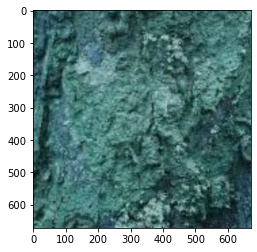

In [130]:
plt.imshow(frame)

### Preparing source and target data

In [2]:
source_dataset_path = '/datadrive/barknet_1.0'
target_dataset_path = '/datadrive/notebooks/downloaded_data/full_data_top_23_0.1_resize_672_672/'

with open('/datadrive/barknet.metadata') as json_file:
        source_dataset_metadata = json.load(json_file)

with open('/datadrive/bdfr.metadata') as json_file:
        target_dataset_metadata = json.load(json_file)
        
source_generate_dataset = GenerateDataset(source_dataset_path, source_dataset_metadata)
target_generate_dataset = GenerateDataset(target_dataset_path, target_dataset_metadata)

source_generate_dataset.load_dataset('None')
target_generate_dataset.load_dataset('None')

source_dataset_splits = source_generate_dataset.all_dataset()
target_dataset_splits = target_generate_dataset.all_dataset()



In [3]:
source_train_data = source_dataset_splits['train']
source_val_data = source_dataset_splits['val']
source_test_data = source_dataset_splits['test']

target_train_data = target_dataset_splits['train']
target_val_data = target_dataset_splits['val']
target_test_data = target_dataset_splits['test']

In [4]:
batch_size = 128
output_dim = (224, 224)

In [5]:
augmentation_params = {'vertical_flip': True, 'rotation': True, 'channel_shift_range': 10, 'shear_range': 0.2,
                           'horizontal_flip': True, 'random_crop': True}

source_train_image_generator = ImageDatasetGenerator(source_train_data['files'], source_train_data['labels'], batch_size//2, output_dim,
                                        source_dataset_metadata, train_mode=True, **augmentation_params)

source_val_image_generator = ImageDatasetGenerator(source_val_data['files'], source_val_data['labels'], batch_size//2, output_dim,
                                        source_dataset_metadata, train_mode=False, random_crop=False)

target_train_image_generator = ImageDatasetGenerator(target_train_data['files'], target_train_data['labels'], batch_size//2, output_dim,
                                        target_dataset_metadata, train_mode=True, **augmentation_params)

target_val_image_generator = ImageDatasetGenerator(target_val_data['files'], target_val_data['labels'], batch_size//2, output_dim,
                                        target_dataset_metadata, train_mode=False, random_crop=False)



In [6]:
source_ds_train = tf.data.Dataset.from_generator(lambda: source_train_image_generator,
                     output_types=(tf.float32, tf.float32),
                     output_shapes=([batch_size//2, output_dim[0], output_dim[1], 3],
                                    [batch_size//2, 20])
                     )

target_ds_train = tf.data.Dataset.from_generator(lambda: source_train_image_generator,
                     output_types=(tf.float32, tf.float32),
                     output_shapes=([batch_size//2, output_dim[0], output_dim[1], 3],
                                    [batch_size//2, 20])
                     )


source_gen_train = iter(source_ds_train)
target_gen_train = iter(target_ds_train)

In [7]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, InputLayer, GlobalAveragePooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import Model

class MNISTModel(object):
    """Simple MNIST domain adaptation model."""
    def __init__(self, extractor_model=None):
        self.extractor_model = extractor_model
        self._build_model()

        
    def _build_model(self):
        input_shape = (224, 224, 3)
        output_pooling = False
        output_shape = 20
        
        #Feature extractor definition.
        
        input_features = Input(input_shape)
        
        if self.extractor_model is None:
            output_1 = Conv2D(filters=32, kernel_size=5, padding='SAME')(input_features)
            output_2 = MaxPooling2D(2, strides=2, padding='SAME')(output_1)
            output_3 = Conv2D(filters=48, kernel_size=5, padding='SAME')(output_2)
            output_4 = MaxPooling2D(2, strides=2, padding='SAME')(output_3)
            if output_pooling:
                final_output = GlobalAveragePooling2D()(output_4)
            else:
                final_output = Flatten()(output_4)
        else:
            
            base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
            base_model.trainable = True
            for layer in base_model.layers:
                if 'conv5_block3' not in layer.name:
                    layer.trainable = False
                else:
                    print(f'Layer trainable {layer.name}')
                    
            output_1 = preprocess_input(input_features)
            output_2 = base_model(output_1, training=False)
            final_output = GlobalAveragePooling2D()(output_2)
            
        self.feature_extractor_model = Model(inputs=input_features, outputs=final_output)
        print("Feature extractor model summary: ")
        self.feature_extractor_model.summary()
        
        #Source classifier definition.
        source_output_1 = Dense(units=100)(final_output)
        source_output_2 = Dense(units=100)(source_output_1)
        source_final_output = Dense(units=output_shape, activation='softmax')(source_output_2)
        self.source_classifier_model = Model(inputs=input_features, outputs=source_final_output)
        print("Source classifier model summary: ")
        print(self.source_classifier_model.summary())
        
        #Domain classifier definition.
        #kernel_regularizer=tf.keras.regularizers.l2()
        domain_output_1 = Dense(units=100)(final_output)
        domain_final_output = Dense(units=1, 
                                    activation='sigmoid')(domain_output_1)
        self.domain_classifier_model = Model(inputs=input_features, outputs=domain_final_output)
        print("Domain classifier model summary: ")
        print(self.domain_classifier_model.summary())
        
        #Combined model definition (source classifier + domain classifier).
        self.combined_model = Model(inputs=input_features, outputs=[source_final_output, domain_final_output])
        
        print("Combined model summary: ")
        print(self.combined_model.summary())

In [8]:
model = MNISTModel(extractor_model='resnet_50')

Layer trainable conv5_block3_1_conv
Layer trainable conv5_block3_1_bn
Layer trainable conv5_block3_1_relu
Layer trainable conv5_block3_2_conv
Layer trainable conv5_block3_2_bn
Layer trainable conv5_block3_2_relu
Layer trainable conv5_block3_3_conv
Layer trainable conv5_block3_3_bn
Layer trainable conv5_block3_add
Layer trainable conv5_block3_out
Feature extractor model summary: 
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________

In [9]:
# Build optimizers
from tensorflow.keras.optimizers import SGD, Adam,Adagrad
from  tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, BinaryAccuracy, CategoricalAccuracy
#domain_optimizer = SGD(momentum=0.9)
domain_optimizer = Adam(1e-4)
#combined_model_optimizer = SGD(momentum=0.9)
combined_model_optimizer = Adam(1e-4)

metrics=["accuracy"]

#model.domain_classifier_model.compile(loss='binary_crossentropy', optimizer=domain_optimizer, metrics=metrics)

#model.combined_model.compile(loss=['sparse_categorical_crossentropy', 'binary_crossentropy'], 
#                             optimizer=combined_model_optimizer, metrics=metrics)

In [10]:
def custom_train_on_batch(X, y, model, optimizer, loss_function, metrics_function = None, trainable_variables=None):
    with tf.GradientTape() as tape:
        pred = model(X)
        loss = loss_function(y, pred)
        metrics_results = {}
        if metrics_function:
            metrics_results = metrics_function(y, pred)
    if not trainable_variables:
        trainable_variables = model.trainable_variables
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    results = {'loss': loss}
    results.update(metrics_results)
    return results
    

In [11]:
num_steps = 8600

domain_labels = np.vstack([np.tile([1.], [batch_size // 2, 1]),
                                   np.tile([0.], [batch_size // 2, 1])])

opposite_domain_labels = np.vstack([np.tile([0.], [batch_size // 2, 1]),
                                   np.tile([1.], [batch_size // 2, 1])])

sample_weights_class  = np.array(([1] * (batch_size // 2) + [0] * (batch_size // 2)))

sample_weights_adversarial = np.ones((batch_size,))

weights = [sample_weights_class, sample_weights_adversarial]
    

domain_binary_metric = BinaryAccuracy()
source_classifier_metric = CategoricalAccuracy()
source_classifier_cum_loss = tf.keras.metrics.CategoricalCrossentropy()
target_classifier_cum_loss = tf.keras.metrics.CategoricalCrossentropy()
target_classifier_metric = CategoricalAccuracy()

def custom_loss_function(y_true, y_pred):
    
    sample_weight_class = weights[0]
    sample_weight_domain = weights[1]
    y_class = y_true[0]
    y_domain = y_true[1]
    y_pred_class = y_pred[0]
    y_pred_domain = y_pred[1]
    classifier_loss = CategoricalCrossentropy()(y_class, y_pred_class, sample_weight=sample_weight_class)
    domain_loss = BinaryCrossentropy()(y_domain, y_pred_domain, sample_weight=sample_weight_domain)
    return classifier_loss + -1 * domain_loss


def domain_metrics_functions(y, pred):
    domain_binary_metric.update_state(y, pred)
    result = domain_binary_metric.result()
    return {domain_binary_metric.name: result}

def combine_model_metrics_functions(y, pred):
    source_classifier_metric.update_state(y[0], pred[0], weights[0])
    source_result = source_classifier_metric.result()
    
    #target_classifier_metric.update_state(y[0], pred[0], 1 - weights[0])
    #target_result = target_classifier_metric.result()
    
    source_classifier_cum_loss.update_state(y[0], pred[0], weights[0])
    source_loss_result = source_classifier_cum_loss.result()
    
    #target_classifier_cum_loss.update_state(y[0], pred[0], 1 - weights[0])
    #target_loss_result = target_classifier_cum_loss.result()
            
    return {f'source_{source_classifier_metric.name}': source_result, 
            #f'target_{target_classifier_metric.name}': target_result,
           f'source_{source_classifier_cum_loss.name}': source_loss_result,}
           #f'target_{target_classifier_cum_loss.name}': target_loss_result}
    
loss_print = 100

#Training in adversarial manner.
for i in range(num_steps):
    
    #p = float(i) / num_steps
    #lr = 0.01 / (1. + 10 * p)**0.75
    #domain_optimizer.lr = lr   
    #combined_model_optimizer.lr = lr
    
    
    source_X, source_y = next(source_gen_train)
    target_X, target_y = next(target_gen_train)

    X = np.vstack([source_X, target_X])
    y = np.vstack([source_y, target_y])
    #Training domain classifier.

    domain_classifier_stats = custom_train_on_batch(X, 
                                                    domain_labels, 
                                                    model.domain_classifier_model,
                                                    domain_optimizer,
                                                    BinaryCrossentropy(),
                                                    metrics_function=domain_metrics_functions)
    
    #Training source classifier and feature extractor together to fool domain classifier.
    # We expect 0.5 accuracy for domain classifier.

    labels = [y, domain_labels]
    
    combined_model_stats = custom_train_on_batch(X, 
                                                    labels, 
                                                    model.combined_model,
                                                    combined_model_optimizer,
                                                    custom_loss_function,
                                                    metrics_function=combine_model_metrics_functions)
    
    if i % loss_print == 0:
        print(combined_model_stats)
        domain_loss = domain_classifier_stats['loss']
        domain_accuracy = domain_classifier_stats['binary_accuracy']
        combined_model_loss = combined_model_stats['loss']
        source_accuracy = combined_model_stats['source_categorical_accuracy']
        #target_accuracy = combined_model_stats['target_sparse_categorical_accuracy']
        source_cum_loss = combined_model_stats['source_categorical_crossentropy']
        #target_cum_loss = combined_model_stats['target_sparse_categorical_crossentropy']
        print('---------------------------------------------------')
        print(f'Iteration: {i}')
        print(f'Domain Classifier Loss: {domain_loss}')
        print(f'Domain Classifier Accuracy: {domain_accuracy}')
        print(f'Combined model Loss: {combined_model_loss}')
        print(f'Source Classifier Loss: {source_cum_loss}')
        #print(f'Target Classifier Loss: {target_cum_loss}')
        print(f'Source Accuracy: {source_accuracy}')
        #print(f'Target Accuracy: {target_accuracy}')
        #print(f'Actual learning rate: {lr}')
        print('---------------------------------------------------')
        print()


{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.1362774>, 'source_categorical_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.078125>, 'source_categorical_crossentropy': <tf.Tensor: shape=(), dtype=float32, numpy=4.005685>}
---------------------------------------------------
Iteration: 0
Domain Classifier Loss: 1.145437240600586
Domain Classifier Accuracy: 0.46875
Combined model Loss: 1.136277437210083
Source Classifier Loss: 4.005684852600098
Source Accuracy: 0.078125
---------------------------------------------------

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.064459085>, 'source_categorical_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.23917079>, 'source_categorical_crossentropy': <tf.Tensor: shape=(), dtype=float32, numpy=2.5536778>}
---------------------------------------------------
Iteration: 100
Domain Classifier Loss: 1.3003270626068115
Domain Classifier Accuracy: 0.5030167102813721
Combined model Loss: 0.06445908546447754
Source Classifier 

KeyboardInterrupt: 

In [ ]:
#tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
#dann_tsne = tsne.fit_transform(dann_emb)
#dann_tsne.shape

In [ ]:
#plot_embedding(source_only_tsne, combined_test_labels.argmax(1), combined_test_domain.argmax(1), 'Source only')
#plot_embedding(dann_tsne, combined_test_labels.flatten(), combined_test_domain[:, 0], 'Domain Adaptation')

In [ ]:
#tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
#source_only_tsne = tsne.fit_transform(source_only_emb)

#tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
#dann_tsne = tsne.fit_transform(dann_emb)
        
#plot_embedding(source_only_tsne, combined_test_labels.argmax(1), combined_test_domain.argmax(1), 'Source only')
#plot_embedding(dann_tsne, combined_test_labels.argmax(1), combined_test_domain.argmax(1), 'Domain Adaptation')